# LSTM + XGBoost Approach

After tweaking the neural network it appears the the LSTM neural network provides a better ouput for most of the year except for the December and January period. This could be for a few reasons: 

1) LSTM is not

What I would like to test is creating an Ensemble machine learning algorithmn to combine the strengths of both. There are two approaches I would like to try:

- __Time-Split Ensemble__: We run the LSTM for all months of the year apart from Decemeber-January
- __Stacking__: Feed the XGBoost values into an LSTM to aid with prediction

Will then compare how these models are performing with respect to residuals.

In [1]:
import os
import numpy as np
import pickle
import sys
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
sys.path.append('C:/projects/python/time-series-analysis')

def load_processed_data(file_path):
    # Load each array from the corresponding file
    X_train = np.load(os.path.join(file_path, "X_train.npy"), allow_pickle=True)
    X_test = np.load(os.path.join(file_path, "X_test.npy"), allow_pickle=True)
    y_train = np.load(os.path.join(file_path, "y_train.npy"), allow_pickle=True)
    y_test = np.load(os.path.join(file_path, "y_test.npy"), allow_pickle=True)
    split_point_dates = np.load(os.path.join(file_path, "split_point_dates.npy"), allow_pickle=True)

    # Load column names
    with open(os.path.join(file_path, "column_names.pkl"), 'rb') as f:
        feature_names = pickle.load(f)
    
    return X_train, X_test, y_train, y_test, split_point_dates, feature_names

# Specify the directory where the processed data is saved
directory_path = "../data/processed/machine_learning"

# Load the processed data
X_train, X_test, y_train, y_test, split_point_dates, feature_names = load_processed_data(directory_path)

In [2]:
from src.models.XGBoost import XGBTimeSeriesTrainer
from src.models.LSTM import LSTMTimeSeriesTrainer
from src.models.XGBRegressor import GBMTimeSeriesTrainer
from src.models.GRU import GRUTimeSeriesTrainer
from src.models.KNN import KNNTimeSeriesTrainer

In [3]:
from src.util.Plot_Model import plot_charts
from src.util.Evaluate_Model import evaluate_model
from src.util.Feature_Importance import rank_feature_importance, get_neural_network_feature_importance

In [4]:
import mlflow
mlflow.end_run()

We first want to instantiate the LSTM and XGBoost Classes

In [5]:
xgb_model = XGBTimeSeriesTrainer()
xgb_model.load_model()

epochs = 5000
sequence_length = 15
learning_rate = 0.001
dropout = 0.1
weight_decay=0.01

lstm_model = LSTMTimeSeriesTrainer(dropout=dropout, weight_decay=weight_decay)
lstm_model.load_model()

Model and scaler loaded.
Using device: cuda
Scaler loaded.
Model loaded.


In [9]:
xgb_predictions = xgb_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

def time_split_ensemble(xgb_predictions, lstm_predictions, split_dates):

    predictions = []
    
    for i in range(len(X_test)):
        if split_point_dates[i].month == 12:
            predictions.append(xgb_predictions[i])
        else:
            predictions.append(lstm_predictions[i])

    return predictions


In [10]:
ts_predictions = time_split_ensemble(xgb_predictions, lstm_predictions, split_point_dates)
ts_predictions_array = array = np.array(ts_predictions)

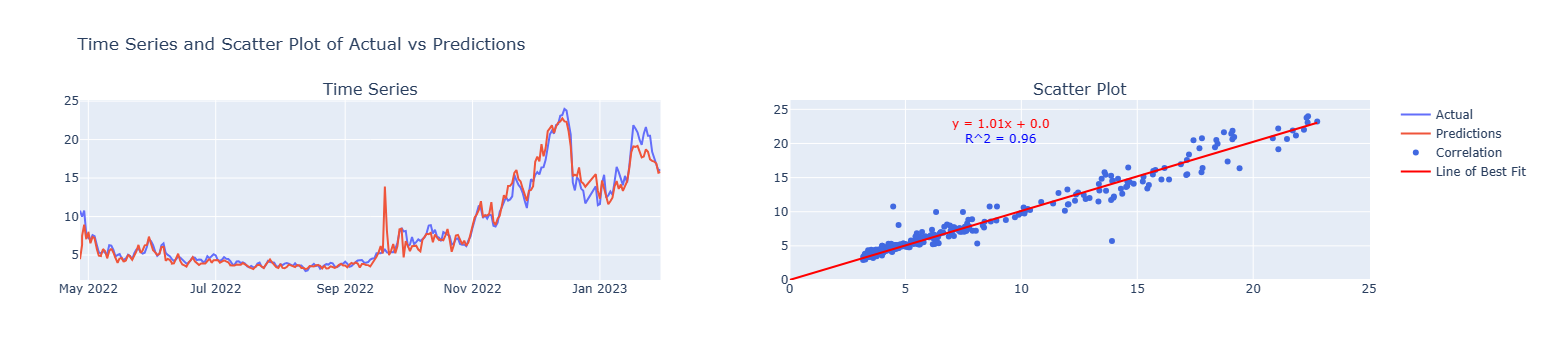

In [11]:
with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "XGBoost - LSTM Time-Series-Ensemble")
    ts_gradient, ts_intercept, ts_r2, ts_mape = evaluate_model(ts_predictions_array, y_test)
    plot_charts(ts_predictions_array, y_test, split_point_dates, ts_gradient, ts_intercept, ts_r2, run_id=run.info.run_id)

mlflow.end_run()